# 📘 Bias–Variance Tradeoff (with Diagrams)

This notebook builds intuition for the **bias–variance tradeoff** with theory and simulations.  
You’ll see:  
- Formal decomposition of prediction error  
- U-shape test error vs. model complexity  
- Learning curves (train vs. validation error)  
- Visualizing high variance via repeated fits  


## 1. Theory: Decomposition

Let the data be generated by \( y = f(x) + \varepsilon \), where \( \varepsilon \) is noise with \( \mathbb{E}[\varepsilon]=0 \) and \( \mathrm{Var}(\varepsilon)=\sigma^2 \).
For a predictor \( \hat f(x) \), the expected squared prediction error at a point \(x\) decomposes as:
$$
\mathbb{E}\big[(y - \hat f(x))^2\big]
\;=\;
\underbrace{\big(\mathbb{E}[\hat f(x)] - f(x)\big)^2}_{\text{Bias}^2}
\;+\;
\underbrace{\mathbb{E}\big[(\hat f(x)-\mathbb{E}[\hat f(x)])^2\big]}_{\text{Variance}}
\;+\;
\underbrace{\sigma^2}_{\text{Irreducible noise}}.
$$

- **Bias**: error from **wrong assumptions** / overly simple models (underfitting).  
- **Variance**: error from **sensitivity to data** / overly flexible models (overfitting).  
- **Irreducible noise**: error you cannot remove no matter what model you pick.


In [1]:
# 2. Setup
%pip -q install numpy matplotlib scikit-learn

import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

rng = default_rng(42)

def true_function(x):
    # Smooth non-linear function to make under/overfit visible
    return np.sin(1.5 * x) + 0.25 * x

def make_data(n=80, noise=0.2, x_range=(-3, 3), seed=None):
    r = default_rng(seed) if seed is not None else rng
    X = r.uniform(x_range[0], x_range[1], size=n)
    X = np.sort(X)
    y = true_function(X) + r.normal(0.0, noise, size=n)
    return X.reshape(-1, 1), y


Note: you may need to restart the kernel to use updated packages.


## 2. U-Shape: Error vs. Model Complexity

We’ll sweep polynomial degree and plot **train** and **validation** MSE.  
Expect: train error ↓ with complexity, validation error becomes **U-shaped**.


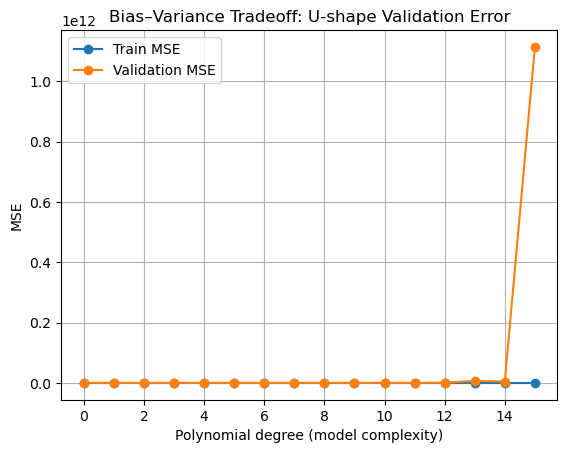

In [2]:
# Generate a fixed train/validation split
X, y = make_data(n=140, noise=0.25, seed=0)
n_train = 90
X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:], y[n_train:]

degrees = list(range(0, 16))  # from constant model up to degree 15
train_mse, val_mse = [], []

for d in degrees:
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=d, include_bias=True)),
        ("lin", LinearRegression(fit_intercept=False))  # bias term from poly
    ])
    model.fit(X_train, y_train)
    train_mse.append(mean_squared_error(y_train, model.predict(X_train)))
    val_mse.append(mean_squared_error(y_val, model.predict(X_val)))

plt.figure()
plt.plot(degrees, train_mse, marker="o", label="Train MSE")
plt.plot(degrees, val_mse, marker="o", label="Validation MSE")
plt.xlabel("Polynomial degree (model complexity)")
plt.ylabel("MSE")
plt.title("Bias–Variance Tradeoff: U-shape Validation Error")
plt.legend()
plt.grid(True)
plt.show()


## 3. Learning Curves (Underfit vs. Good Fit vs. Overfit)

For a **fixed model**, plot error as we increase training size:  
- Underfit: high train & validation error, small gap.  
- Good fit: both errors low and close.  
- Overfit: low train, high validation, large gap.


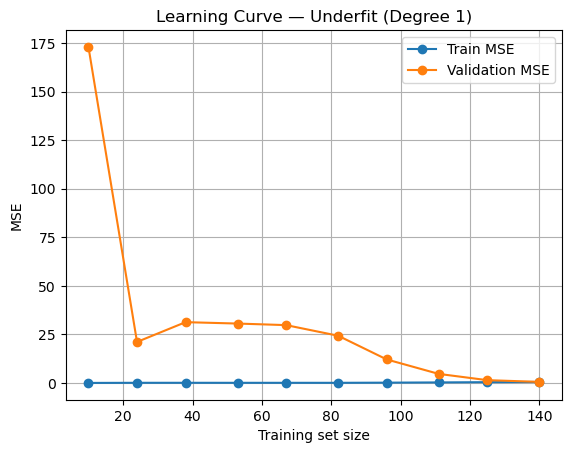

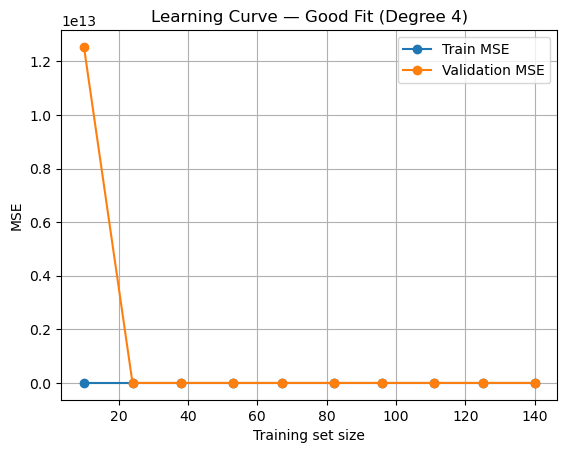

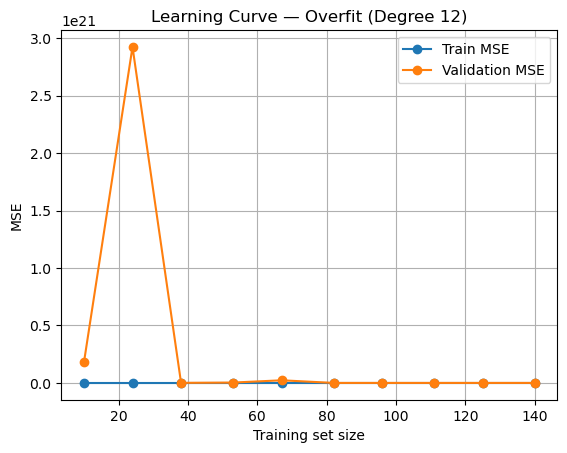

In [3]:
def learning_curve_for_degree(degree, train_sizes, seed=123):
    X_all, y_all = make_data(n=max(train_sizes)+60, noise=0.25, seed=seed)
    # Hold out a validation set at the end
    X_val, y_val = X_all[-60:], y_all[-60:]
    train_errors, val_errors = [], []
    for m in train_sizes:
        X_train, y_train = X_all[:m], y_all[:m]
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=degree, include_bias=True)),
            ("lin", LinearRegression(fit_intercept=False))
        ])
        model.fit(X_train, y_train)
        train_errors.append(mean_squared_error(y_train, model.predict(X_train)))
        val_errors.append(mean_squared_error(y_val, model.predict(X_val)))
    return train_errors, val_errors

train_sizes = np.linspace(10, 140, 10, dtype=int)

# Underfit (degree=1), Good fit (degree=4), Overfit (degree=12)
for deg, title in [(1, "Underfit (Degree 1)"),
                   (4, "Good Fit (Degree 4)"),
                   (12,"Overfit (Degree 12)")]:
    tr, va = learning_curve_for_degree(deg, train_sizes)
    plt.figure()
    plt.plot(train_sizes, tr, marker="o", label="Train MSE")
    plt.plot(train_sizes, va, marker="o", label="Validation MSE")
    plt.xlabel("Training set size")
    plt.ylabel("MSE")
    plt.title(f"Learning Curve — {title}")
    plt.legend()
    plt.grid(True)
    plt.show()


## 4. Visualizing Variance (Repeated Fits)

We fit the **same high-capacity model** on many bootstrap resamples.  
If variance is high, the fitted curves will wiggle a lot across runs.


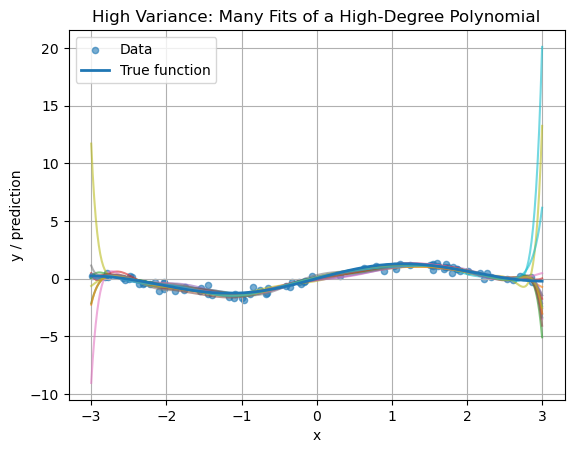

In [4]:
# Base data
X_base, y_base = make_data(n=80, noise=0.25, seed=77)
x_plot = np.linspace(-3, 3, 300).reshape(-1, 1)
y_true = true_function(x_plot.ravel())

degree = 14  # intentionally high capacity
n_models = 20

plt.figure()
plt.scatter(X_base, y_base, s=20, alpha=0.6, label="Data")
for i in range(n_models):
    X_bs, y_bs = resample(X_base, y_base, replace=True, n_samples=len(X_base), random_state=i)
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=True)),
        ("lin", LinearRegression(fit_intercept=False))
    ])
    model.fit(X_bs, y_bs)
    y_hat = model.predict(x_plot)
    plt.plot(x_plot, y_hat, alpha=0.6)

plt.plot(x_plot, y_true, linewidth=2.0, label="True function")
plt.xlabel("x")
plt.ylabel("y / prediction")
plt.title("High Variance: Many Fits of a High-Degree Polynomial")
plt.legend()
plt.grid(True)
plt.show()


## 5. Practical Guidance

- Use **validation curves** to select model complexity.  
- Inspect **learning curves** to diagnose under/overfitting.  
- Reduce **variance** with more data, regularization, or simpler models.  
- Reduce **bias** with richer features, higher-capacity models, or nonlinearity.  
- Remember: **irreducible noise** sets a floor on achievable error.


## Appendix: Quick Glossary

- **Bias**: Systematic error from simplifying assumptions.  
- **Variance**: Sensitivity to data fluctuations.  
- **Capacity/Complexity**: How flexible the model class is.  
- **Generalization**: Performance on unseen data.  
- **Regularization**: Techniques that penalize complexity to reduce variance.
